In [2]:
import requests
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from datetime import datetime
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Збір даних

Функція create_file_if_not_exists створює файл з вказаним ім'ям та заголовками, якщо його не існує

In [4]:
def create_file_if_not_exists(file_name, headers):
    if not os.path.exists(file_name):
        with open(file_name, 'w', newline = '') as new_file:
            csv_writer = csv.writer(new_file)
            csv_writer.writerow(headers)

Функція read_existing_data зчитує існуючі дані з csv-файлу

In [5]:
def read_existing_data(file_name):
    existing_data = []
    with open(file_name, 'r', newline = '') as csvfile:
        csv_reader = csv.reader(csvfile)
        existing_data.extend(row for row in csv_reader if len(row) > 0 and row[0] != 'Date')
    return existing_data

Функція write_data_to_file записує дані у файл

In [6]:
def write_data_to_file(file_name, headers, new_data, existing_data):
    with open(file_name, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)

        # Запис заголовків у CSV-файл
        csv_writer.writerow(headers)
        
        # Запис існуючих даних
        csv_writer.writerows(existing_data)

        # Запис нових даних
        for item in new_data['results']:
            data_date = datetime.utcfromtimestamp(item['t'] / 1000).strftime('%Y-%m-%d')
            if data_date not in [row[0] for row in existing_data]:
                csv_writer.writerow([data_date, item['v'], item['vw'], item['o'], item['c'], item['h'], item['l'], item['t'], item['n']])

Отримання даних з API та запис їх у файл з використанням вище наведених функцій

In [7]:
current_date = datetime.now().strftime('%Y-%m-%d')
file_name = 'BTC.csv'
headers = ['Date', 'Volume', 'VWAP', 'Open', 'Close', 'High', 'Low', 'Timestamp', 'Number of items']

url = f"https://api.polygon.io/v2/aggs/ticker/X:BTCUSD/range/1/day/2021-01-01/{current_date}"
params = {
    'apiKey': 'ic3ZxxKF59kJRP_JXDqOF1YI9hQyorXE'
}

response = requests.get(url, params=params)

if response.status_code == 200:
    new_data = response.json()
    create_file_if_not_exists(file_name, headers)
    existing_data = read_existing_data(file_name)
    write_data_to_file(file_name, headers, new_data, existing_data)
    print(f"Дані успішно додано або вже існують у файлі {file_name}")
else:
    print(f"Помилка отримання даних. Статус код: {response.status_code}")
    print(response.text)

Дані успішно додано або вже існують у файлі BTC.csv


Date: Дата, коли відбулася торгівля.  
Volume: Об'єм торгів за вказаний період.  
VWAP (Volume Weighted Average Price): Середня ціна акцій за період, вагована за об'ємом торгів.  
Open: Ціна відкриття акцій на початку торгівельного періоду.  
Close: Ціна закриття акцій в кінці торгівельного періоду.  
High: Найвища ціна акцій за вказаний період.  
Low: Найнижча ціна акцій за вказаний період. 
Timestamp: Час у форматі мілісекунд з деякого визначеного епохального моменту.  
Number of items: Кількість торгових позицій (угод) за вказаний період.  

In [8]:
with open(file_name, 'r', newline='') as csvfile:
    # Створення об'єкта для читання CSV
    csv_reader = csv.reader(csvfile)

    # Виведення заголовків
    headers = next(csv_reader)
    print(headers)

    # Виведення усіх записів
    for row in csv_reader:
        print(row)

['Date', 'Volume', 'VWAP', 'Open', 'Close', 'High', 'Low', 'Timestamp', 'Number of items']
['2021-12-05', '35410.57709591021', '49073.956', '49240.81', '49484.22', '49783', '47827', '1638662400000', '826685']
['2021-12-06', '39853.01854168593', '48888.1183', '49484.21', '50529.56', '51105', '47111', '1638748800000', '849462']
['2021-12-07', '22445.896288456042', '51056.8686', '50529.56', '50650.1', '51995', '50062.13', '1638835200000', '584342']
['2021-12-08', '21770.404293102623', '50145.7114', '50624.46', '50519.68', '51275', '48579.3', '1638921600000', '526786']
['2021-12-09', '26330.6028418892', '48777.5209', '50520.94', '47568.43', '50844.86', '47298.4', '1639008000000', '661906']
['2021-12-10', '29888.65814228431', '48199.5268', '47568.41', '47170.94', '50212', '46886', '1639094400000', '718129']
['2021-12-11', '19726.721151804068', '48418.8373', '47170.94', '49426', '49539.4', '46786.78', '1639180800000', '529317']
['2021-12-12', '17538.251389379744', '49793.1485', '49420.51', '

### Обробка даних

Запис даних у dataframe для подальшого аналізу

In [10]:
# Функція для визначення значення "Category" на основі "Number of items"
def assign_interval(value):
    if value <= 500000:
        return 0
    elif 500000 < value <= 1000000:
        return 1
    elif 100000 < value <= 1500000:
        return 2
    elif 1500000 < value <= 2000000:
        return 3
    elif 2000000 < value <= 2500000:
        return 4
    elif 2500000 < value:
        return 5
    
# Зчитуємо дані з CSV-файлу
df = pd.read_csv(file_name)

# Додаємо стовпець "Category" за допомогою функції apply
df['Category'] = df['Number of items'].apply(assign_interval)

# Виводимо перші 5 записів DataFrame
print(df.head())

         Date        Volume        VWAP      Open     Close      High  \
0  2021-12-05  35410.577096  49073.9560  49240.81  49484.22  49783.00   
1  2021-12-06  39853.018542  48888.1183  49484.21  50529.56  51105.00   
2  2021-12-07  22445.896288  51056.8686  50529.56  50650.10  51995.00   
3  2021-12-08  21770.404293  50145.7114  50624.46  50519.68  51275.00   
4  2021-12-09  26330.602842  48777.5209  50520.94  47568.43  50844.86   

        Low      Timestamp  Number of items  Category  
0  47827.00  1638662400000           826685         1  
1  47111.00  1638748800000           849462         1  
2  50062.13  1638835200000           584342         1  
3  48579.30  1638921600000           526786         1  
4  47298.40  1639008000000           661906         1  


##### Очистка даних

In [11]:
print(f'Кіількість null значень в кожному стовпчику:\n{df.isnull().sum()}')

Кіількість null значень в кожному стовпчику:
Date               0
Volume             0
VWAP               0
Open               0
Close              0
High               0
Low                0
Timestamp          0
Number of items    0
Category           0
dtype: int64


In [12]:
print(f'Кількість дублікатів: {df.duplicated().sum()}')

Кількість дублікатів: 0


In [13]:
print(f'Типи даних:\n{df.dtypes}')

Типи даних:
Date                object
Volume             float64
VWAP               float64
Open               float64
Close              float64
High               float64
Low                float64
Timestamp            int64
Number of items      int64
Category             int64
dtype: object


In [14]:
print(f'Розмірність даних: {df.shape}')

Розмірність даних: (733, 10)


In [15]:
print(f'Кількість унікальних дат: {df.Date.nunique()}')

Кількість унікальних дат: 733


In [16]:
print(f'Основі показники:\n{df.describe()}')

Основі показники:
              Volume          VWAP          Open         Close          High  \
count     733.000000    733.000000    733.000000    733.000000    733.000000   
mean    25283.837398  28791.436239  28802.387373  28793.699798  29415.664850   
std     17119.113719   8791.221732   8808.945037   8792.437631   9030.611294   
min      2428.615138  15949.458000  15766.000000  15759.720000  16294.500000   
25%     13750.199487  21407.007200  21526.220000  21528.340000  21909.800000   
50%     21959.471455  27346.555400  27324.050000  27300.000000  27829.700000   
75%     31741.049192  35194.329100  35449.100000  35440.100000  36113.590000   
max    141785.563684  51224.160700  50857.420000  50851.380000  52111.000000   

                Low     Timestamp  Number of items   Category  
count    733.000000  7.330000e+02     7.330000e+02  733.00000  
mean   28174.803605  1.670285e+12     5.303993e+05    0.54161  
std     8568.053233  1.829461e+10     2.782164e+05    0.63373  
min  

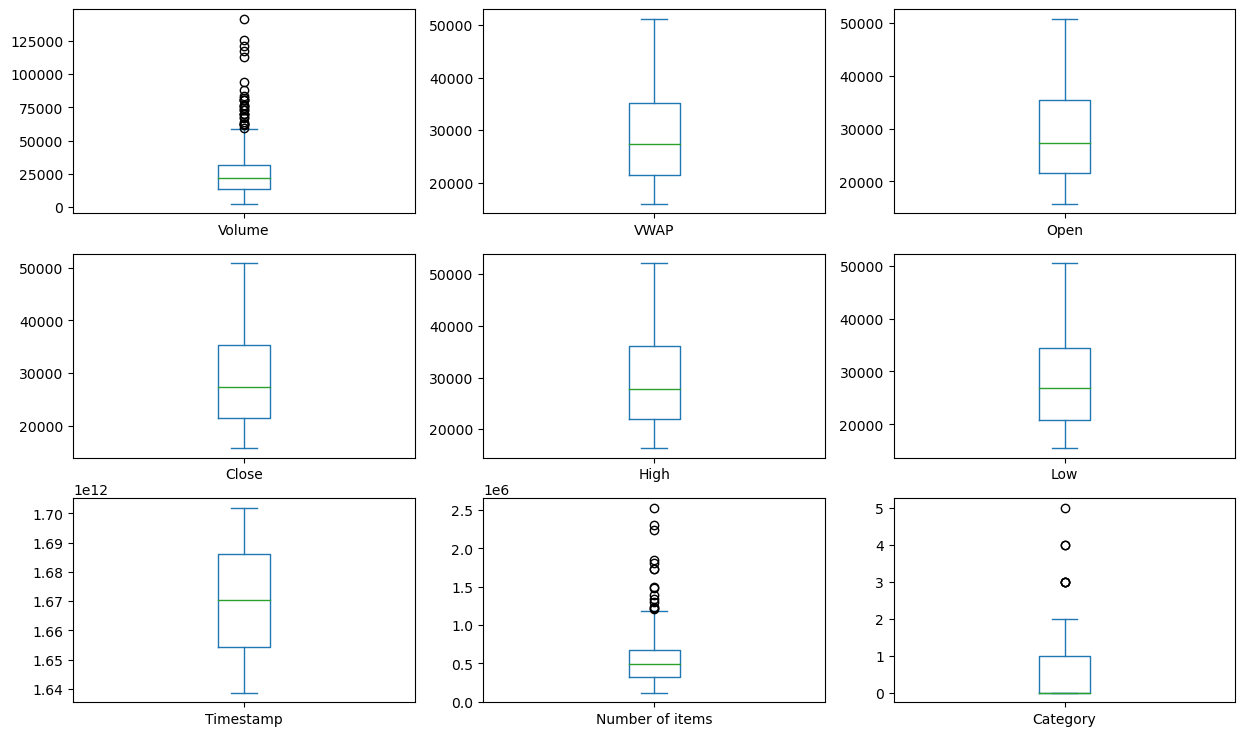

In [17]:
df.plot(subplots=True, layout=(3, 3), kind='box', figsize=(15, 9))

plt.show()

Матриця кореляції

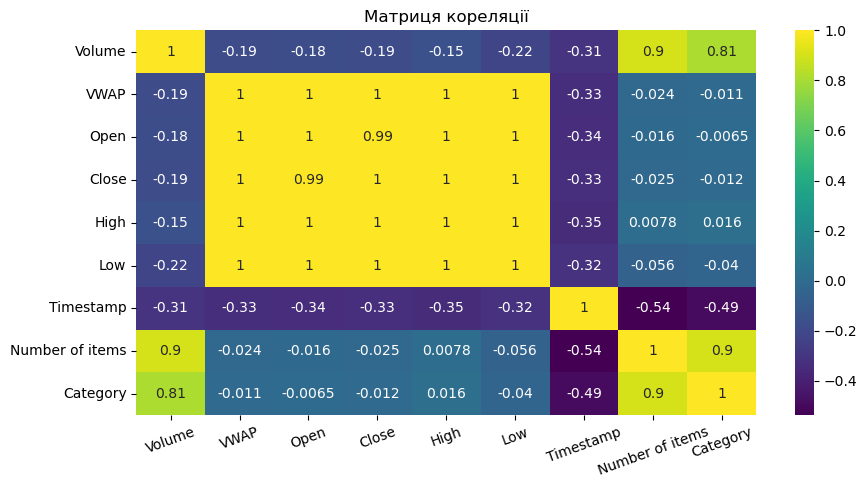

In [18]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='viridis')
plt.title('Матриця кореляції')
plt.xticks(rotation=20)
plt.show()

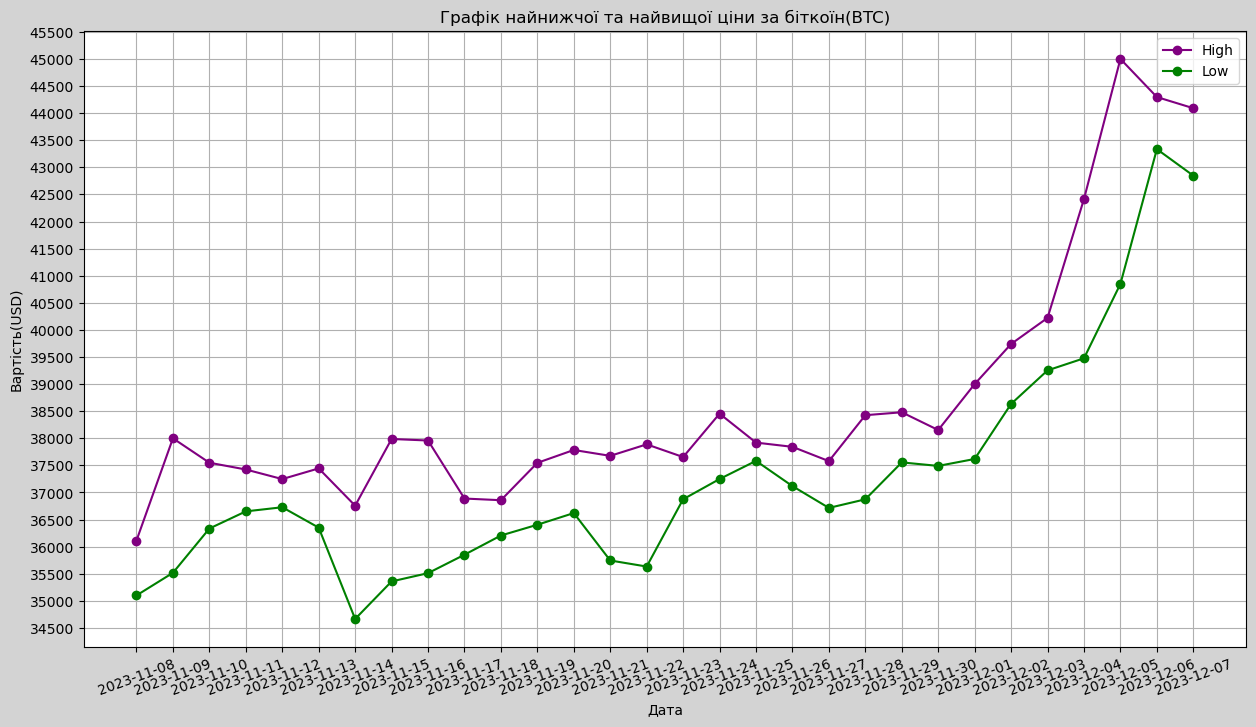

In [19]:
df_last_30 = df.iloc[-30:]

plt.figure(figsize=(15, 8), facecolor='lightgrey')

plt.plot(df_last_30.Date, df_last_30.High, marker='o', color='purple')
plt.plot(df_last_30.Date, df_last_30.Low, marker='o', color='green')

plt.gca().yaxis.set_major_locator(MultipleLocator(500))

plt.xticks(rotation=20)
plt.xlabel('Дата')
plt.ylabel('Вартість(USD)')
plt.title('Графік найнижчої та найвищої ціни за біткоїн(BTC)')
plt.grid()
plt.legend(['High','Low'])

plt.show()

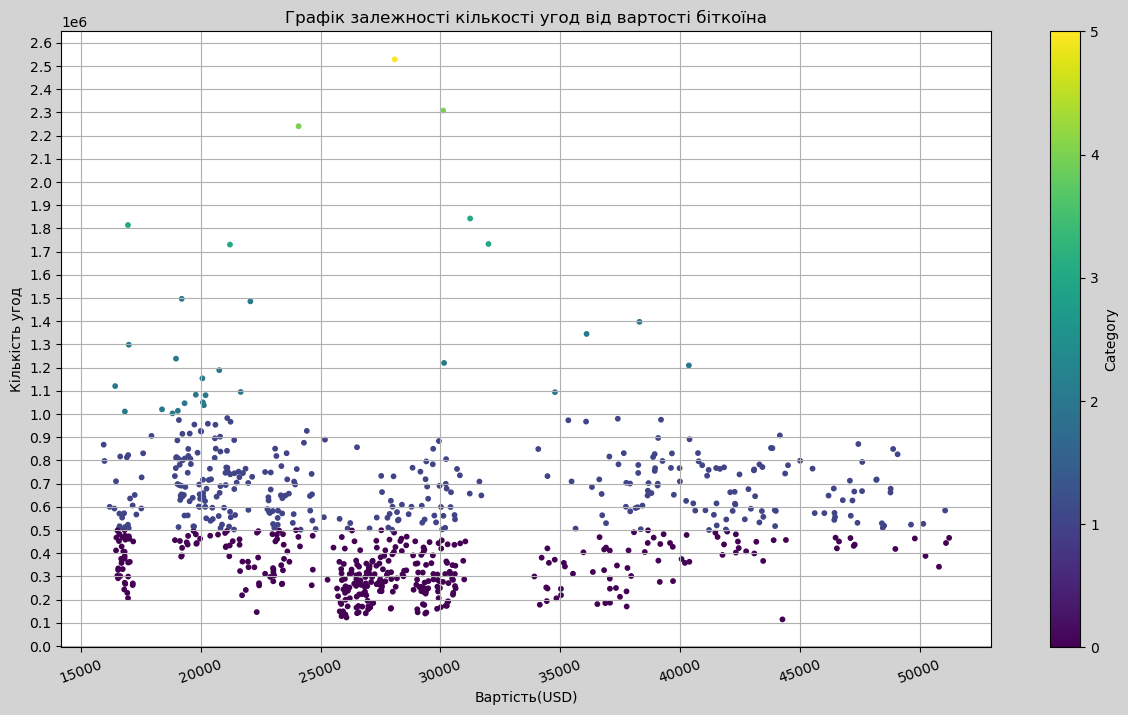

In [37]:
plt.figure(figsize=(15, 8), facecolor='lightgrey')

plt.scatter(df.VWAP, df['Number of items'], marker='o', c=df['Category'], s=10, cmap='viridis')

plt.gca().xaxis.set_major_locator(MultipleLocator(5000))
plt.gca().yaxis.set_major_locator(MultipleLocator(100000))
plt.xticks(rotation=20)
plt.xlabel('Вартість(USD)')
plt.ylabel('Кількість угод')
plt.title('Графік залежності кількості угод від вартості біткоїна')
plt.grid()

#Шкала кольору
cbar = plt.colorbar()
cbar.set_label('Category')

plt.show()

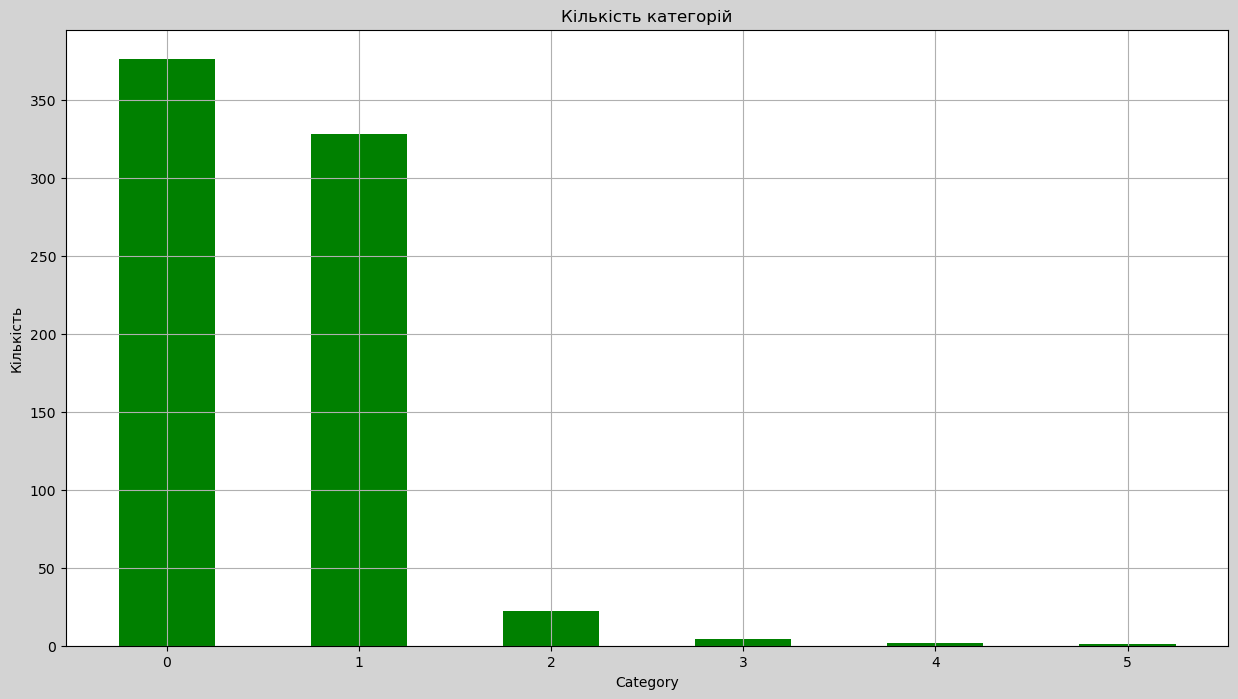

In [26]:
plt.figure(figsize=(15, 8), facecolor='lightgrey')

category_counts = df['Category'].value_counts()

plt.bar(category_counts.index, interval_counts.values, color='green', width=0.5)

plt.xlabel('Category')
plt.ylabel('Кількість')
plt.title('Кількість категорій')
plt.grid()

plt.show()

### Побудова моделей прогнозування

Підготовка даних для тренування моделей

In [27]:
scaler = StandardScaler()

x = df.drop(['Date', 'Number of items', 'Category' ], axis=1)
y = df['Category']

X_st = scaler.fit_transform(x)

Розділяємо дані на тренувальні і валідаційні

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_st, y, test_size=0.25, random_state=42)

#### RandomForest

In [29]:
forest = RandomForestClassifier(random_state=42)
%timeit forest.fit(X_train, y_train)

210 ms ± 18.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
y_pred = forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91        95
           1       0.84      0.92      0.88        79
           2       0.50      0.33      0.40         6
           3       1.00      0.33      0.50         3
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1

    accuracy                           0.88       184
   macro avg       0.55      0.41      0.45       184
weighted avg       0.88      0.88      0.87       184



#### Bootstrap(bagging)

In [31]:
bagging_classifier = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42)
bagging_classifier.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

In [32]:
y_pred = bagging_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        95
           1       0.88      0.86      0.87        79
           2       0.43      0.50      0.46         6
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1

    accuracy                           0.86       184
   macro avg       0.37      0.38      0.38       184
weighted avg       0.86      0.86      0.86       184



#### XGBoost

In [33]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, y_test)

params = {'max_depth': 4}

model = xgb.train(params, dtrain, 100)

y_pred = model.predict(dtest)

In [34]:
y_pred = [round(v) for v in y_pred]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92        95
           1       0.88      0.87      0.88        79
           2       0.50      0.33      0.40         6
           3       0.67      0.67      0.67         3
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1

    accuracy                           0.88       184
   macro avg       0.49      0.47      0.48       184
weighted avg       0.88      0.88      0.88       184



#### LogisticRegression

In [35]:
logreg = LogisticRegression(random_state=42)
%timeit logreg.fit(X_train, y_train)

17.4 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
y_pred_logreg = logreg.predict(X_test)
print(classification_report(y_test, y_pred_logreg))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92        95
           1       0.86      0.90      0.88        79
           2       0.33      0.33      0.33         6
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1

    accuracy                           0.87       184
   macro avg       0.35      0.36      0.36       184
weighted avg       0.86      0.87      0.86       184



### Висновок

Бачимо що у всіх чотирьох моделей - RandomForest, Bootstrap (Bagging), XGBoost та Logistic Regression - точність (accuracy) приблизно однакова. Це означає, що загалом всі моделі виявляються досить ефективними в даній задачі класифікації.

Однак, аналізуючи метрики precision, recall та F1-Score для окремих класів, можна помітити, що Logistic Regression трохи гірше справляється за інші моделі з проблемними класами(3,4,5,6). 

Отже, найкращою моделлю для прогнозування для цієї задачі є RandomFores.